# Introduction

## Contexte et objectifs

Dans le cadre de ce travail pratique d'analyse et classification de données, nous nous éloignons de la base initiale proposée (feuilles d'arbres) pour explorer un domaine riche en données et particulièrement passionnant : **la Formule 1**.

Ce sport mécanique d'excellence présente des caractéristiques analytiques fascinantes :
- Performances multidimensionnelles (pilote, écurie, stratégie, conditions)
- Données précises et exhaustives disponibles
- Enjeux de classification naturelle entre différents niveaux de performance

**Objectif principal** :  
Analyser les performances des pilotes sur plusieurs saisons pour établir une classification non supervisée selon leurs résultats.

## Méthodologie

Nous mettrons en œuvre les techniques suivantes :

1. **Réduction de dimension** :
   - Analyse en Composantes Principales (ACP)

2. **Clustering** :
   - Algorithme K-means
   - Détermination du nombre optimal de classes :
     - Méthode du coude
     - Indice de silhouette
     - Classification Ascendante Hiérarchique (CAH)
   - Éventuellement régression logistique pour une classification binaire (ex: podium/non-podium)

3. **Analyse comparative** :
   - Clustering sur données brutes vs. sur composantes principales
   - Temps de calcul et interprétabilité

## Source des données

Base de données publique :  
**'Formula 1 World Championship (1950-2024)'** (Kaggle)  
Contenant :
- Résultats détaillés de toutes les courses
- Statistiques par pilote et par écurie
- Classements saisonniers complets

## Valeur attendue

Cette étude permettra de :
1. Identifier des regroupements naturels entre :
   - Pilotes d'élite ("top drivers")
   - Pilotes de milieu de grille
   - Autres catégories
2. Évaluer l'apport de l'ACP en prétraitement
3. Fournir des insights sur l'évolution des performances



In [106]:
import pandas as pd
import numpy as np
# Load the main CSVs
drivers = pd.read_csv('drivers.csv')
races = pd.read_csv('races.csv')
driver_standings = pd.read_csv('driver_standings.csv')
results = pd.read_csv('results.csv')
constructors = pd.read_csv('constructors.csv')

# Merge races with driver_standings to get year
standings = driver_standings.merge(races[['raceId', 'year']], on='raceId')

# Merge with drivers to get driver names
standings = standings.merge(drivers[['driverId', 'driverRef', 'surname']], on='driverId')

# Keep only final race of each season (to get final position)
final_standings = standings.sort_values('raceId', ascending=False).drop_duplicates(['driverId', 'year'])

# Aggregate per driver-season
driver_season_df = final_standings[['driverId', 'driverRef', 'surname', 'year', 'points', 'wins', 'position']].copy()

# Convert columns
driver_season_df['points'] = driver_season_df['points'].astype(float)
driver_season_df['wins'] = driver_season_df['wins'].astype(int)
driver_season_df['position'] = pd.to_numeric(driver_season_df['position'], errors='coerce')
driver_season_df = driver_season_df.dropna()

# Add binary target (top 3 or not)
driver_season_df['top3'] = driver_season_df['position'] <= 3

driver_season_df.head()


,driverId,driverRef,surname,year,points,wins,position,top3
34855,839,ocon,Ocon,2024,23.0,0,14,False
34851,817,ricciardo,Ricciardo,2024,12.0,0,17,False
34858,858,sargeant,Sargeant,2024,0.0,0,23,False
34857,822,bottas,Bottas,2024,0.0,0,22,False
34856,842,gasly,Gasly,2024,42.0,0,10,False


In [107]:
# Unique drivers (can be viewed as 'classes')
unique_drivers = driver_season_df['driverRef'].unique()
print(f"Nombre de pilotes différents : {len(unique_drivers)}")
print("Exemple de pilotes :", unique_drivers[:10])


Nombre de pilotes différents : 854
Exemple de pilotes : ['ocon' 'ricciardo' 'sargeant' 'bottas' 'gasly' 'kevin_magnussen'
 'colapinto' 'doohan' 'lawson' 'norris']


## Préparation des données pour le clustering

### Features sélectionnées
J'utiliserai les 3 variables suivantes comme features d'entrée:
- **points** : Score total des équipes
- **wins** : Nombre de victoires
- **positions** : Classement final


In [108]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = driver_season_df[['points', 'wins', 'position']].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


Je vais essayer de trouver K ici avec la methode  Elbow + Silhouette : inertie Elbo et Silhouette score et inttérpreter K a partir des graphique.

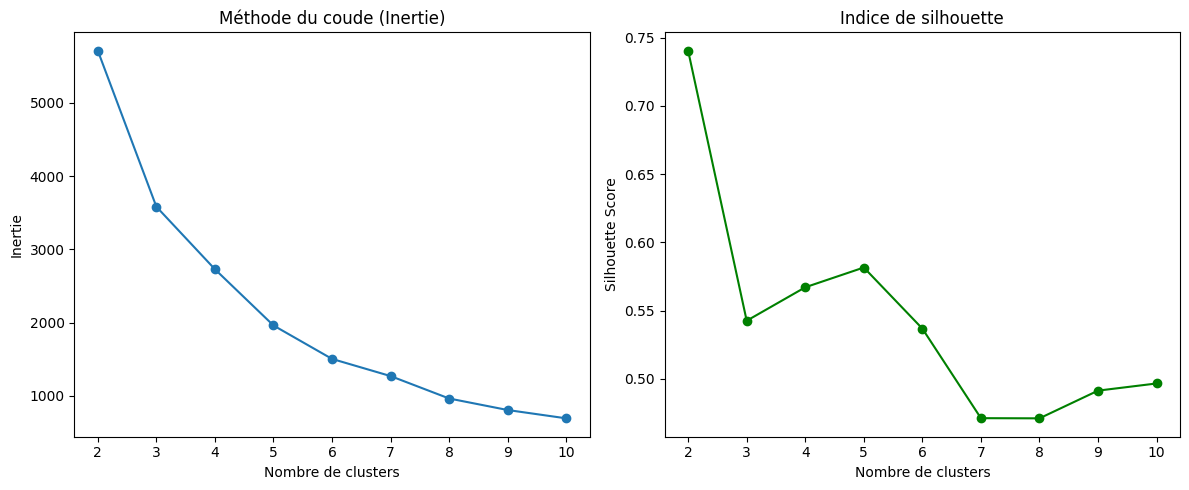

In [109]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette = []

K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(K_range, inertia, marker='o')
ax[0].set_title('Méthode du coude (Inertie)')
ax[0].set_xlabel('Nombre de clusters')
ax[0].set_ylabel('Inertie')

ax[1].plot(K_range, silhouette, marker='o', color='green')
ax[1].set_title('Indice de silhouette')
ax[1].set_xlabel('Nombre de clusters')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


### Interprétation des résultats de clustering

#### 1. Méthode du coude (Inertie)
- On recherche un "coude" dans la courbe d'inertie
- Un coude visible apparaît vers **K = 3** ou **K = 4**

#### 2. Indice de silhouette
- L'indice le plus élevé est à **K = 2**, mais:
  - Cela donnerait une partition un peu trop grossière (trop peu de clusters)
- Le score se stabilise entre **K = 4** et **K = 5**

#### Conclusion
Un bon compromis entre inertie et qualité de clustering serait:
- **K = 4**  
  Car il équilibre:
  - Une inertie assez basse
  - Un score de silhouette encore correct
 

In [110]:
from sklearn.cluster import KMeans

kmeans_final = KMeans(n_clusters=4, random_state=42)
labels_k4 = kmeans_final.fit_predict(X_scaled)

# Ajout des labels à la dataframe
driver_season_df['cluster'] = labels_k4


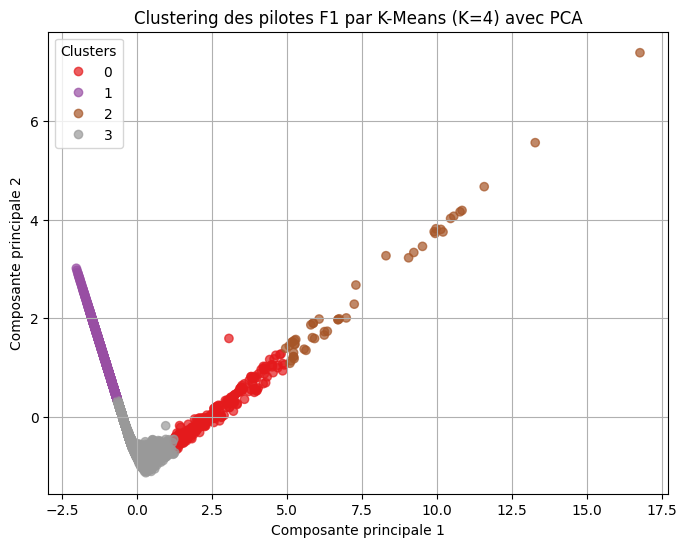

In [111]:
from sklearn.decomposition import PCA

# Reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=driver_season_df['cluster'], cmap='Set1', alpha=0.7)
plt.title("Clustering des pilotes F1 par K-Means (K=4) avec PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()


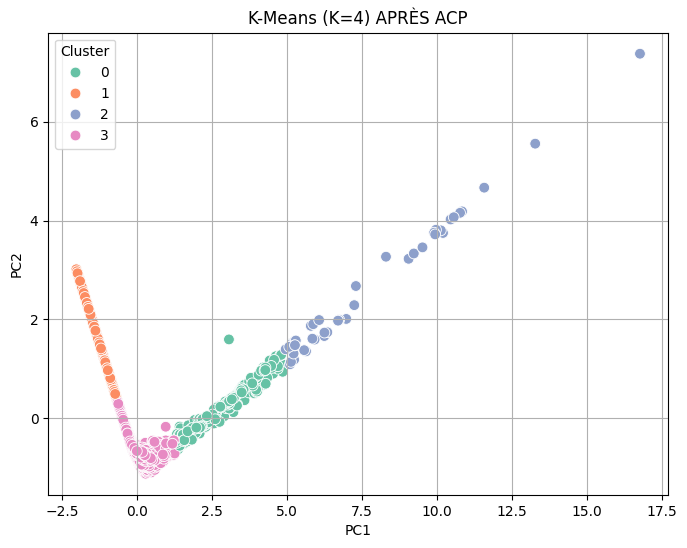

In [112]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Nouvelle visualisation
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_k4, palette='Set2', s=60)
plt.title("K-Means (K=4) APRÈS ACP")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()


In [113]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, driver_season_df['cluster'])
print(f"Silhouette Score final (K=4): {score:.4f}")

Silhouette Score final (K=4): 0.5671


Je viens ici de présenter les donnés et les interprétaion : je présente ici les Tops 10 pilotes apparteneat a chaque cluster  

In [114]:
# Get top drivers from each cluster
for cluster_num in range(4):
    print(f"\nCluster {cluster_num} - Top Performers:")
    cluster_data = driver_season_df[driver_season_df['cluster'] == cluster_num]
    # Sort by points and show top 10
    display(cluster_data.sort_values('points', ascending=False)[['year', 'driverRef', 'points', 'wins', 'position']].head(10))



Cluster 0 - Top Performers:


,year,driverRef,points,wins,position
34846,2024,piastri,292.0,2,4
34841,2024,sainz,290.0,2,5
34323,2023,perez,285.0,2,2
33863,2022,russell,275.0,1,4
32550,2019,leclerc,264.0,2,4
28887,2011,webber,258.0,1,3
28886,2011,alonso,257.0,1,4
31257,2016,ricciardo,256.0,1,3
32128,2018,raikkonen,251.0,1,3
32131,2018,max_verstappen,249.0,2,4



Cluster 1 - Top Performers:


,year,driverRef,points,wins,position
29826,1994,inoue,0.0,0,45
27455,1950,murray,0.0,0,56
27442,1950,rol,0.0,0,59
27532,1950,pian,0.0,0,70
27534,1950,fohr,0.0,0,42
15603,1976,hoshino,0.0,0,43
15609,1976,andersson,0.0,0,45
15610,1976,hayje,0.0,0,42
15634,1976,ashley,0.0,0,44
14940,1977,takahara,0.0,0,48



Cluster 2 - Top Performers:


,year,driverRef,points,wins,position
34322,2023,max_verstappen,575.0,19,1
33878,2022,max_verstappen,454.0,15,1
34839,2024,max_verstappen,437.0,9,1
32547,2019,hamilton,413.0,11,1
32127,2018,hamilton,408.0,11,1
29798,2013,vettel,397.0,13,1
33354,2021,max_verstappen,395.5,10,1
28883,2011,vettel,392.0,11,1
33353,2021,hamilton,387.5,8,2
31254,2016,rosberg,385.0,9,1



Cluster 3 - Top Performers:


,year,driverRef,points,wins,position
28899,2011,rosberg,89.0,0,7
31710,2017,ocon,87.0,0,8
1912,2004,button,85.0,0,3
31261,2016,bottas,85.0,0,8
33868,2022,alonso,81.0,0,9
33371,2021,alonso,81.0,0,10
30774,2015,perez,78.0,0,9
28901,2011,michael_schumacher,76.0,0,8
32917,2020,stroll,75.0,0,11
34327,2023,stroll,74.0,0,10


Ci  dessous je vias présenter la  Moyenne  des features : points, position et wins pour chaque cluster ( ceci me permet de identidier la nature du chaque driver : Top driver rookie etc 


Average Performance by Cluster:


,points,wins,position
cluster,,,
0,93.728302,2.381132,3.743396
1,0.000000,0.000000,62.496474
2,278.638298,7.617021,1.553191
3,7.166702,0.064026,20.103178


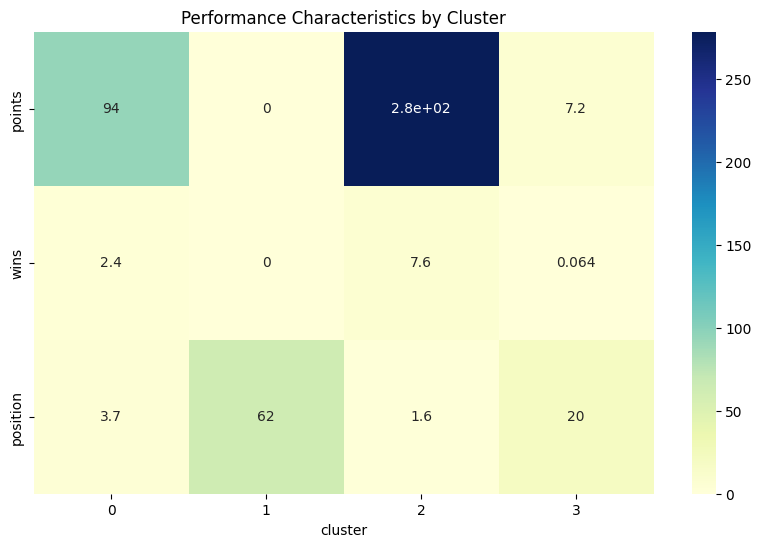

In [115]:
# Calculate mean values per cluster
cluster_stats = driver_season_df.groupby('cluster')[['points', 'wins', 'position']].mean()
print("\nAverage Performance by Cluster:")
display(cluster_stats)

# Visualize cluster characteristics
plt.figure(figsize=(10,6))
sns.heatmap(cluster_stats.T, annot=True, cmap='YlGnBu')
plt.title("Performance Characteristics by Cluster")
plt.show()

D'apres les resultatat  je vais albeler chauqe cluster : 

In [116]:
# Define cluster labels based on performance
cluster_labels = {
    2: "Elite Champions",       # Highest points, most wins, top positions
    0: "Strong Contenders",     # Good points, some wins
    3: "Midfield Performers",   # Moderate points, few wins
    1: "Backmarkers"           # Low points, rarely score
}

# Add labels to dataframe
driver_season_df['cluster_label'] = driver_season_df['cluster'].map(cluster_labels)

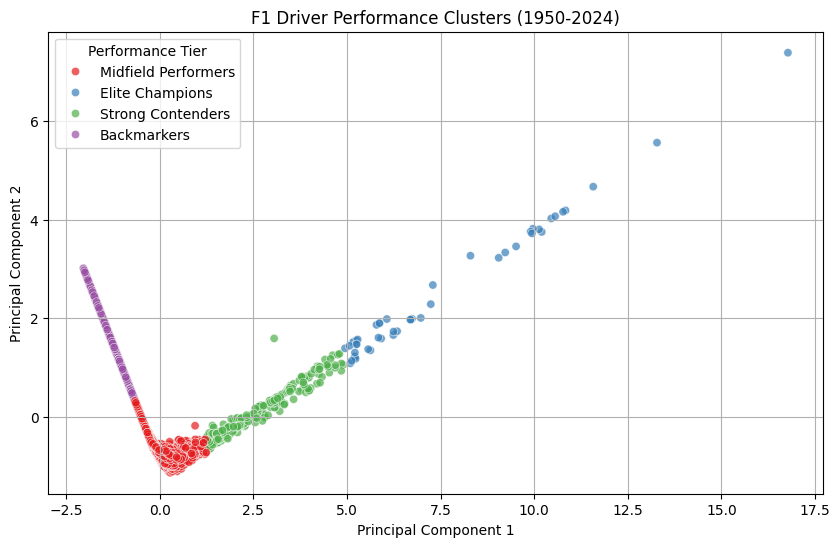

In [117]:
# Plot with actual labels
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=driver_season_df['cluster_label'],
    palette='Set1',
    alpha=0.7
)
plt.title("F1 Driver Performance Clusters (1950-2024)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Performance Tier")
plt.grid(True)
plt.show()

In [118]:
# Display top 5 drivers from each labeled cluster
for label_name in cluster_labels.values():
    print(f"\n=== {label_name} ===")
    display(
        driver_season_df[driver_season_df['cluster_label'] == label_name].sort_values('points', ascending=False) [['year', 'driverRef', 'points', 'wins', 'position']].head(5)
        )



=== Elite Champions ===


,year,driverRef,points,wins,position
34322,2023,max_verstappen,575.0,19,1
33878,2022,max_verstappen,454.0,15,1
34839,2024,max_verstappen,437.0,9,1
32547,2019,hamilton,413.0,11,1
32127,2018,hamilton,408.0,11,1



=== Strong Contenders ===


,year,driverRef,points,wins,position
34846,2024,piastri,292.0,2,4
34841,2024,sainz,290.0,2,5
34323,2023,perez,285.0,2,2
33863,2022,russell,275.0,1,4
32550,2019,leclerc,264.0,2,4



=== Midfield Performers ===


,year,driverRef,points,wins,position
28899,2011,rosberg,89.0,0,7
31710,2017,ocon,87.0,0,8
1912,2004,button,85.0,0,3
31261,2016,bottas,85.0,0,8
33868,2022,alonso,81.0,0,9



=== Backmarkers ===


,year,driverRef,points,wins,position
29826,1994,inoue,0.0,0,45
27455,1950,murray,0.0,0,56
27442,1950,rol,0.0,0,59
27532,1950,pian,0.0,0,70
27534,1950,fohr,0.0,0,42


# Clustering par Classification Ascendante Hiérarchique (CAH)

## Utilisant les Donées préparés de dessus : 


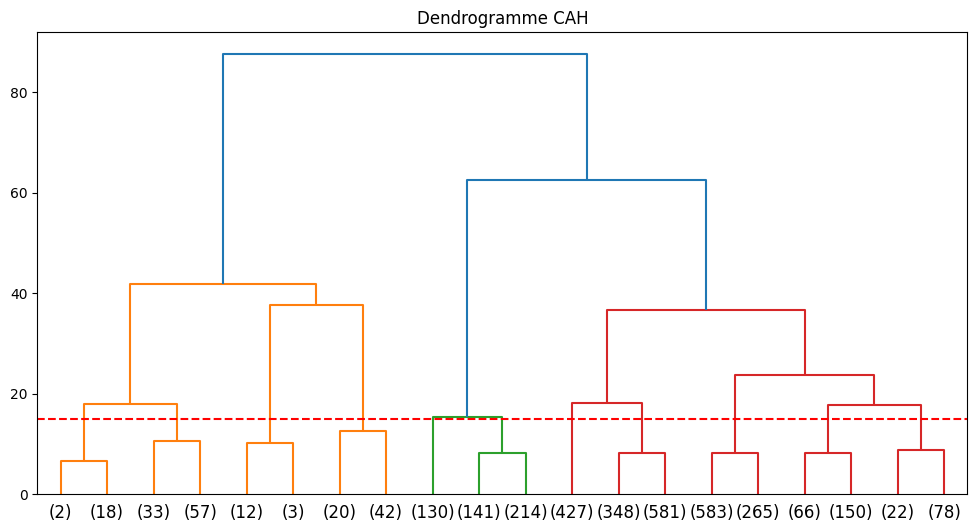

In [119]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Calcul de la matrice de lien
Z = linkage(X_scaled, method='ward')

# Affichage du dendrogramme
plt.figure(figsize=(12, 6))
plt.title("Dendrogramme CAH")
dendrogram(Z, truncate_mode='lastp', p=20)
plt.axhline(y=15, color='r', linestyle='--')  # Seuil de coupure
plt.show()

# Analyse du Dendrogramme CAH

## Interprétation visuelle

Le dendrogramme montre les fusions hiérarchiques avec :
- **Axe vertical** : Distance de fusion (dissimilarité entre clusters)
- **Axe horizontal** : Observations individuelles (pilotes)

Points clés observables :
- Plusieurs fusions à basse distance (similarité forte)
- Un saut important de distance entre (265) et (66) → coude potentiel

## Détermination du nombre optimal de clusters

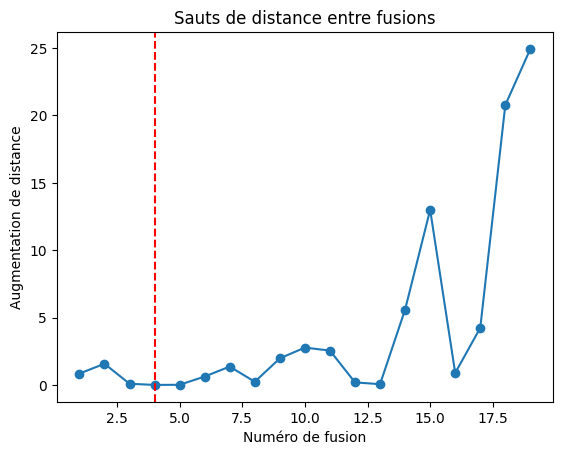

In [125]:
last_merges = Z[-20:, 2]  # 20 dernières fusions
distance_jumps = np.diff(last_merges)

plt.plot(range(1, len(distance_jumps)+1), distance_jumps, 'o-')
plt.axvline(x=4, color='r', linestyle='--')
plt.title('Sauts de distance entre fusions')
plt.xlabel('Numéro de fusion')
plt.ylabel('Augmentation de distance')
plt.show()

## Validation du nombre de clusters


In [126]:
from sklearn.cluster import AgglomerativeClustering

# Création du modèle avec 4 clusters
cah = AgglomerativeClustering(n_clusters=4, linkage='ward')
clusters_cah = cah.fit_predict(X_scaled)

# Ajout des labels au dataframe
driver_season_df['cluster_CAH'] = clusters_cah

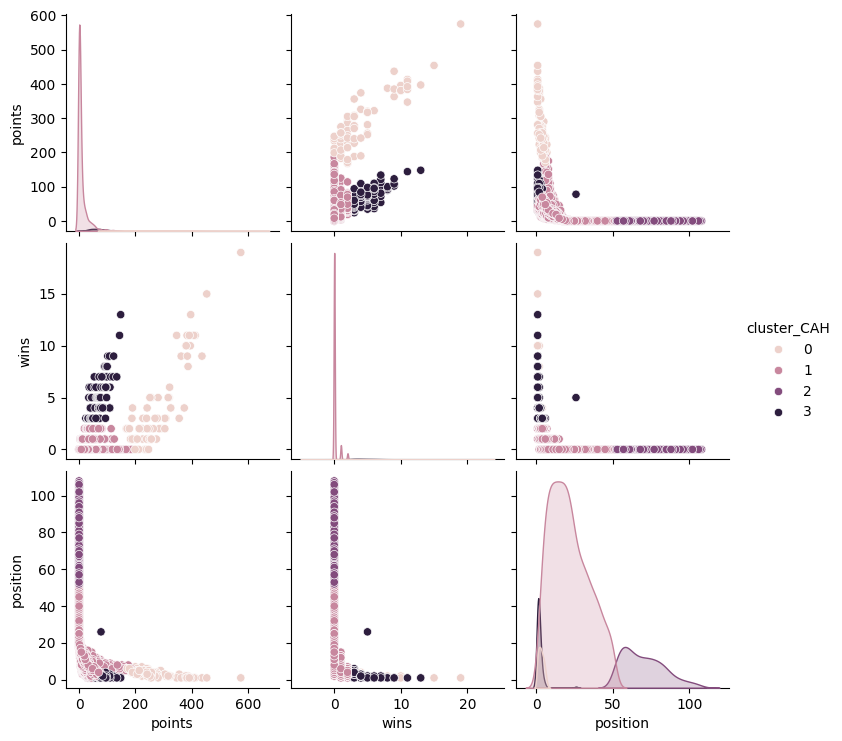

In [124]:
import seaborn as sns

# Pairplot avec hue=cluster_CAH
sns.pairplot(driver_season_df, vars=['points', 'wins', 'position'], hue='cluster_CAH')
plt.show()